In [2]:
import json
import requests
import time
import traceback

In [3]:
# 約定情報
class Execution(object):
    def __init__(self, jsonobj=None):
        if jsonobj:
            self.id = jsonobj['id']
            self.side = jsonobj['side']
            self.price = jsonobj['price']
            self.size = jsonobj['size']
            self.timestamp = jsonobj['exec_date']

    def to_csv_line(self):
        line = '{},{},{},{},{}\n'
        line = line.format(self.id, self.side, self.price,
                           self.size, self.timestamp)
        return line

In [4]:
# bitFlyerのPublic APIを触るためのクラス
class PublicApi(object):

    API_URI = 'https://api.bitflyer.jp/v1/'

    def __init__(self, currency_pair):
        self.currency_pair = currency_pair

    def __get_request(self, endpoint, params=None):
        response = requests.get(endpoint, params=params)
        if response.status_code < 200 or response.status_code >= 300:
            raise Exception('Bad status code {}. Url={}. Body={}'.format(
                response.status_code,
                response.url,
                response.text))
        return response

    def get_executions(self, count=500, before=0, after=0):
        endpoint = PublicApi.API_URI + 'getexecutions'
        params = {
            'product_code': self.currency_pair,
            'count': count,
            'before': before
        }

        if after > 0: params['after'] = after
        response = self.__get_request(endpoint, params=params)
        results = response.json()
        executions = [Execution(x) for x in results]
        return executions

    def save_all_executions(self, csv_file, count=10000):
        """ Get all execution history from public api """
        with open(csv_file, 'w', encoding='utf-8') as f:
            latest = self.get_executions(count=1)
            before = latest[0].id + 1
            saved = 0

            f.write('id,side,price,size,timestamp\n')
            while before > 1:
                try:
                    executions = self.get_executions(before=before)
                    before = executions[-1].id
                    lines = [x.to_csv_line() for x in executions]
                    f.writelines(lines)
                    saved += len(executions)
                    time.sleep(0.12)
                except:
                    print('Failed to process executions. before={}'.format(before))
                    print(traceback.format_exc())

                if count and saved >= count:
                    break

In [5]:
# 直近1000件をダウンロード
public = PublicApi('BTC_JPY')
public.save_all_executions('./executions.csv', count=1000)

In [6]:
# CSVからロードしてくる
import pandas as pd
csv_file = './executions.csv'
df = pd.read_csv(csv_file, parse_dates=['timestamp'])
df.head()

,id,side,price,size,timestamp
0,102463525,SELL,1732148.0,0.453306,2017-12-29 09:22:41.627
1,102463519,BUY,1732998.0,0.017400,2017-12-29 09:22:41.080
2,102463517,BUY,1732000.0,0.200000,2017-12-29 09:22:40.610
3,102463516,BUY,1732000.0,0.265400,2017-12-29 09:22:40.610
4,102463511,SELL,1730941.0,1.311344,2017-12-29 09:22:40.110


In [7]:
# そのままグラフを書いてみる
df[['timestamp', 'price']].set_index('timestamp').plot(figsize=(18,9))

In [8]:
# ローソクチャートを書くために、タイムスタンプの秒以下を切り捨てる。
# ここを調整すると、任意の時間幅で集計できる。
df['timestamp'] = df['timestamp'].map(lambda x: x.replace(second=0, microsecond=0))
df.head()

,id,side,price,size,timestamp
0,102463525,SELL,1732148.0,0.453306,2017-12-29 09:22:00
1,102463519,BUY,1732998.0,0.017400,2017-12-29 09:22:00
2,102463517,BUY,1732000.0,0.200000,2017-12-29 09:22:00
3,102463516,BUY,1732000.0,0.265400,2017-12-29 09:22:00
4,102463511,SELL,1730941.0,1.311344,2017-12-29 09:22:00


In [9]:
# 1分毎の安値と高値(min, max)、始値と終値(first, last)、および取引量(size) を集計
summary = df[['timestamp', 'price']].groupby(['timestamp']).min().rename(columns={'price': 'min'})
summary = summary.merge(
    df[['timestamp', 'price']].groupby(['timestamp']).max().rename(columns={'price': 'max'}),
    left_index=True, right_index=True)
summary = summary.merge(
    df[['timestamp', 'price']].groupby(['timestamp']).last().rename(columns={'price': 'first'}),
    left_index=True, right_index=True)
summary = summary.merge(
    df[['timestamp', 'price']].groupby(['timestamp']).first().rename(columns={'price': 'last'}),
    left_index=True, right_index=True)
summary = summary.merge(
    df[['timestamp', 'size']].groupby(['timestamp']).sum(),
    left_index=True, right_index=True)
summary.head()

,min,max,first,last,size
timestamp,,,,,
2017-12-29 09:08:00,1735000.0,1736282.0,1735000.0,1735001.0,5.647380
2017-12-29 09:09:00,1733820.0,1735000.0,1733820.0,1734999.0,4.056905
2017-12-29 09:10:00,1733820.0,1735000.0,1733820.0,1735000.0,5.708900
2017-12-29 09:11:00,1733000.0,1734547.0,1733000.0,1734199.0,5.080300
2017-12-29 09:12:00,1731200.0,1734121.0,1731200.0,1734121.0,2.605971


Text(0,0.5,'Volume')

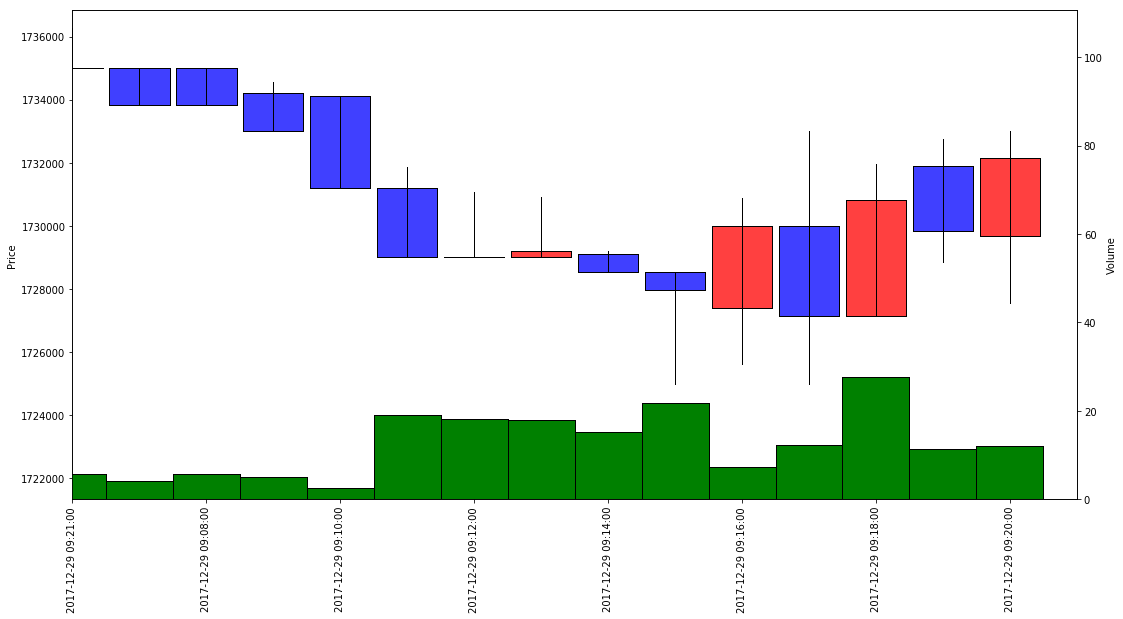

In [10]:
# 下記記事の通りにチャートを描画
# http://www.madopro.net/entry/CandleStickWithPython

import matplotlib.pyplot as plt
from matplotlib.finance import candlestick2_ohlc, volume_overlay

df2 = summary[-1000:]

# ローソク足をプロット
fig = plt.figure(figsize=(18, 9))
ax = plt.subplot(1, 1, 1)
candlestick2_ohlc(ax, df2["first"], df2["max"], df2["min"], df2["last"], width=0.9, colorup="b", colordown="r")
ax.set_xticklabels([(df2.index[int(x)] if x < df2.shape[0] else x) for x in ax.get_xticks()], rotation=90)
ax.set_xlim([0, df2.shape[0]])
ax.set_ylabel("Price")

# ローソク足を上側75%に収める
bottom, top = ax.get_ylim()
ax.set_ylim(bottom - (top - bottom) / 4, top)

# 出来高のチャートをプロット
ax2 = ax.twinx()
volume_overlay(ax2, df2["first"], df2["last"], df2["size"], width=1, colorup="g", colordown="g")
ax2.set_xlim([0, df2.shape[0]])

# 出来高チャートは下側25%に収める
ax2.set_ylim([0, df2["size"].max() * 4])
ax2.set_ylabel("Volume")